# Bayesian Reinforcement Learning

@Shlomo Kashani & Natan Katz.


$$F(x) = I_{x}(p,q) = \frac{\int_{0}^{x}{t^{p-1}(1-t)^{q-1}dt}}{B(p,q)}
\hspace{.2in} 0 \le x \le 1; p, q > 0$$ 

In [10]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import beta
from collections import namedtuple
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules

import warnings
from collections import OrderedDict, defaultdict
from enum import Enum

import numpy as np
from scipy import stats

from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.io import show

from ipywidgets import widgets, interact, interactive
from IPython.display import display 

warnings.simplefilter('ignore', DeprecationWarning)
output_notebook()

%watermark -a 'Shlomo' -d -t -v -p numpy,pandas,matplotlib,scipy
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2


Loading BokehJS ...

Shlomo 2017-06-11 07:56:40 

CPython 2.7.6
IPython 5.3.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.2
scipy 0.19.0
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Multi-armed bandit problem

In the multi-armed bandit problem, we are at a casino (hence ‘bandit’) playing slot machines (hence ‘armed’). 

Given that **not all slot machines have the same payout**, if we are playing two slots, then we are going to start seeing different results from the two machines. 

This leads to the **‘explore vs. exploit dilemma,’** where we are forced to decide between exploiting the **higher-payout machine** and exploring the options (at random) in order to collect more data. 

To any degree that we choose to exploit, we are adapting our behavior to the observed data, and this is one of the general **premises behind reinforcement learning**. 

Our goal is to maximize our reward and minimize our loss by increasing our certainty that we are making the right decision.

There are several strategies one can use to approach the multi-armed bandit problem, including using the Epsilon-Greedy or the UCB algorithm, but this is also where Bayesian inference comes in.

## The notion of Regret

Regret is the difference between your actual payoff and the payoff you would have collected had you played the optimal (best) options at every opportunity.

In [11]:
%autosave 10

Autosaving every 10 seconds


Statistical Distributions
=========================

Let's have a look how different statistical distributions look like, to have a better
idea what to use as prior on bayesian exploration.

All the distributions available in scipy can be found on the docs here: http://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats

Let's start with Discrete distributions

Discrete Distributions
----------------------

* bernoulli:	A Bernoulli discrete random variable.
* binom:	A binomial discrete random variable.


In [12]:
import scipy.stats
from scipy.stats import bernoulli, binom

Bernoulli distribution
-----------------------

For an in depth discussion of PDF's/CDF's see: http://work.thaslwanter.at/Stats/html/statsDistributions.html

Given a probability $p$, the Bernoulli distribution takes value $k=1$, while having $k=0$ in all the other cases $1-p$.

In other words:

$$
f(k;p) = \begin{cases}
    p & \text{if } k=1 \\\\ 
    1-p & \text{if } k=0
\end{cases}
$$

In [13]:
bernoulli.rvs(0.77, size=50)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1])

Bernoulli PDF Visualization
===============

/usr/local/lib/python2.7/dist-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


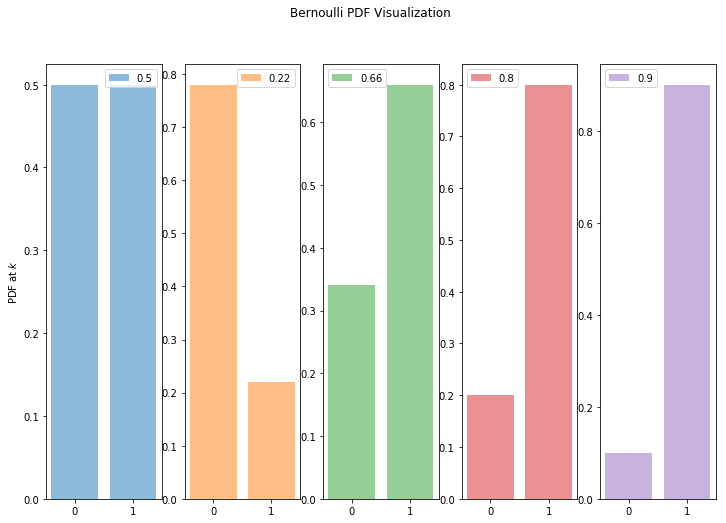

In [14]:
a = np.arange(2)

colors = plt.rcParams['axes.color_cycle']
plt.figure(figsize=(12,8))
for i, p in enumerate([0.5, 0.22, 0.66, 0.8, 0.9]):
    ax = plt.subplot(1, 5, i+1)
    plt.bar(a, bernoulli.pmf(a, p), label=p, color=colors[i], alpha=0.5)
    ax.xaxis.set_ticks(a)

    plt.legend(loc=0)
    if i == 0:
        plt.ylabel("PDF at $k$")    

plt.suptitle("Bernoulli PDF Visualization")

Binomial distribution
---------------------

The Binomial is associated with the question “Out of a given number of trials, how many will succeed?” Some example questions that are modeled with a Binomial distribution are:

Out of ten tosses, how many times will this coin land ”heads”?
From the children born in a given hospital on a given day, how many of them will be girls?
How many students in a given classroom will have green eyes?
How many mosquitos, out of a swarm, will die when sprayed with insecticide?
We conduct nn repeated experiments where the probability of success is given by the parameter $p$ and add up the number of successes. This number of successes is represented by the random variable $X$. The value of $X$ is then between 0 and $n$.

We conduct $n$ repeated experiments where the probability of success is given by the parameter $p$ and add up the number of successes. This number of successes is represented by the random variable $X$. The value of $X$ is then between $0$ and $n$.

The binomial distribution is defined as:

\begin{split}P\left[X = k\right] = \begin{cases} {n \choose k} p^k \left(1-p\right)^{n-k}\ & 0 \le k \le n \\ 0 & \mbox{otherwise} \end{cases} \quad 0 \leq p \leq 1, \quad n \in \mathbb{N}\end{split}

where 

$${n \choose k} = \frac{n!}{k!(n-k)!}$$

with $k={1, 2, 3, \ldots}$

Binomial PMF Visualization
===============

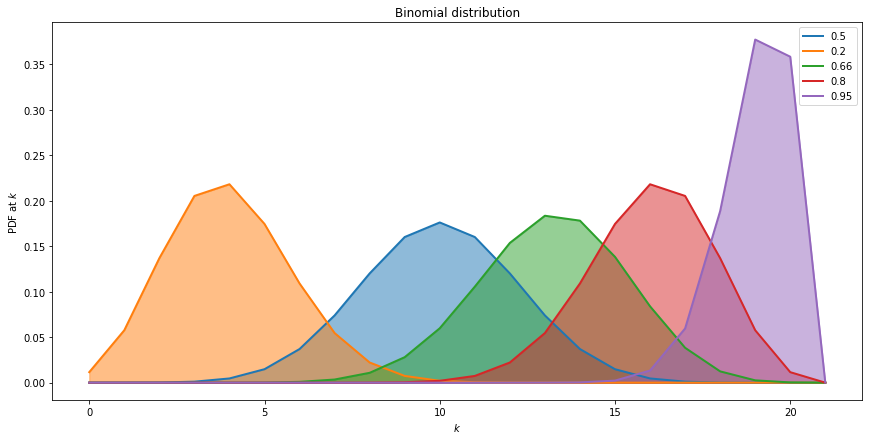

In [15]:
plt.figure(figsize=(12,6))
k = np.arange(0, 22)
for p, color in zip([0.5, 0.2, 0.66, 0.8, .95], colors):
    rv = binom(20, p)
    plt.plot(k, rv.pmf(k), lw=2, color=color, label=p)
    plt.fill_between(k, rv.pmf(k), color=color, alpha=0.5)
plt.legend()
plt.title("Binomial distribution")
plt.tight_layout()
plt.ylabel("PDF at $k$")
plt.xlabel("$k$")


# The Beta distribution (PDF)
-----------------
**The PDF**, or density of a continuous random variable, is a function that describes the relative likelihood for a random variable XX to take on a given value xx. In the mathematical fields of probability and statistics, a random variate x is a particular outcome of a random variable X: the random variates which are other outcomes of the same random variable might have different values.

Since the likelihood to find any given value cannot be less than zero, and since the variable has to have some value, the PDF has the following properties:

$$ PDF(x) \geq 0\,\forall \,x \in \mathbb{R} $$

$$ \int\limits_{ - \infty }^\infty  {PDF(x)dx = 1} $$

![PDF](PDF.png)
*Probability Density Function (PDF) of a value x. The integral over the PDF between a and b gives the likelihood of finding the value of x in that range.*

The Beta distribution is defined for a variabile between 0 and 1. 

The pdf is defined as:

$$
beta.pdf(x, \alpha, \beta) = \frac{1}{B(\alpha, \beta)}x^{\alpha-1}(1 - x)^{\beta-1}, \; with \;  0≤x≤1, \alpha>0, \beta>0
$$

The Beta distribution is very useful in Bayesian statistics, $B$ above is the [Beta function](http://en.wikipedia.org/wiki/Beta_function) (hence the name). 

The random variable $X$ is only allowed in [0,1], making the Beta distribution a popular distribution for decimal values, probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution.

We note that the mean/var of the distribution are:

$$\begin{align} \ E(\theta) = \frac{a}{a+b}, \end{align}$$

$$\begin{align} \ var(\theta) = \frac{ab}{(a+b)^2(a+b+1)} \end{align}$$


## The Beta distribution Visualization

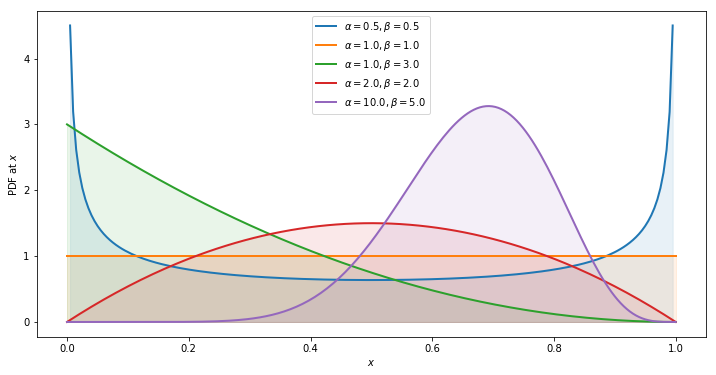

In [ ]:
beta = scipy.stats.beta
x = np.linspace(0,1, num=200)


fig = plt.figure(figsize=(12,6))
for a, b, c in zip([0.5, 1, 1, 2, 10], [0.5, 1, 3, 2, 5], colors):
    plt.plot(x, beta.pdf(x, a, b), lw=2, 
             c=c, label = r"$\alpha = {0:.1f}, \beta={1:.1f}$".format(a, b))
    plt.fill_between(x, beta.pdf(x, a, b), color=c, alpha = .1)
    
    
plt.legend(loc=0)
plt.ylabel("PDF at $x$")
plt.xlabel("$x$")


## CDF (Cumulative Distribution Function) of Beta

The probability to find a value between $a$ and $b$ is given by the integral over the PDF in that range and the Cumulative Distribution Function tells you for each value which percentage of the data has a lower value:

$$\mathbb{P}(a \leq X \leq b) = \int\limits_a^b {PDF(x)dx} = CDF(b) - CDF(a)$$

![CDF-PDF](PDF_CDF.png)
*Probability Density Function (left) and Cumulative distribution function (right) of a normal distribution.*

The formula for the cumulative distribution function of the beta distribution is also called the incomplete beta function ratio (commonly denoted by $Ix$) and is defined as:

$$F(x) = I_{x}(p,q) = \frac{\int_{0}^{x}{t^{p-1}(1-t)^{q-1}dt}}{B(p,q)}
\hspace{.2in} 0 \le x \le 1; p, q > 0$$ 


![CDF](betcdf4.gif)

Show this:
https://www.countbayesie.com/blog/2015/4/4/parameter-estimation-the-pdf-cdf-and-quantile-function


References:
http://www.boost.org/doc/libs/1_35_0/libs/math/doc/sf_and_dist/html/math_toolkit/special/sf_beta/ibeta_function.html


## Mathematical Properties of the Beta Distribution

-- A Beta, specified by parameters $(1,1)$ is **the Uniform distribution**. Hence the Beta distribution is a generalization of the Uniform distribution.

-- The second is that there is an interesting connection between the Beta distribution and the Binomial distribution. Suppose we are interested in some unknown proportion or probability $p$. We assign a $\text{Beta}(\alpha, \beta)$ prior to $p$. We observe some data generated by a Binomial process, say $X \sim \text{Binomial}(N, p)$, with $p$ still unknown. Then our posterior *is again a Beta distribution*, i.e. $p | X \sim \text{Beta}( \alpha + X, \beta + N -X )$. Succinctly, one can relate the two by "a Beta prior with Binomial observations creates a Beta posterior".

In light of the above two paragraphs, if we start with a $\text{Beta}(1,1)$ prior on $p$ (which is a Uniform), observe data $X \sim \text{Binomial}(N, p)$, then our posterior is $\text{Beta}(1 + X, 1 + N - X)$. 

# Bayesian Bandits

The problem we want to solve is the following. 

You have come up with $K$ different variations of a webpage (e.g. different layout) that now you wish to find the ones with the best click through rate (CTR), e.g. clicking to sign-up for the newsletter. 

Let's represent each CTR by $\theta_i$ - i.e., $\theta_i$ is the true probability that an individual user will click when they were shown with the $i_{th}$ webpage. 

It is important to note that we **don't actually know** what $\theta_i$ is - if we did, we could simply choose ii for which $\theta_i$ was largest and move on. We're simply pretending that we know in order to simulate the performance of the algorithm.

Using the Bayesian approach we will construct a prior probability distribution which represents our original belief about what the actual value of $\theta_i$, our ctr for the $i_{th}$ webpage is. The prior we'll use is the Beta distribution. 

## Bayesian Bandits Flow

For each machine, it constructs a beta distribution as a prior. By multiplying it with the likelihood of getting a success, it constructs the posterior distribution for each machine. 

This **posterior** corresponds to our belief at a time point on what the true probability of success is, if we draw from that machine. 

In each step, it samples from each of the posterior distributions. 

It then chooses the sample with the **highest probability**. 

If one machine stands out, clearly, it will be the maximum in most cases, when samples are drawn, and correspond to the exploit phase. Whereas, if two machine have similar posterior distribution, this means, to a Bayesian, from our knowledge, we aren't very sure, who is better. So, in a sense then, the maximum is more likely to come from either distribution. 

In plain English, this is how Thompson sampling solves the explore exploit dilemma mentioned above.

Here's a quick recap of the distribution:

## Show Beta-Binom Notebook

https://github.com/QuantScientist/deep-ml-meetups/blob/master/bayesian-deep-learning/python/BetaBinSymbolically.ipynb


Observations: The mean of each distribution gradually converges around its true value. 

But we can see that the highest-payout bandit has the lowest variance, which is a reflection of the fact that it has the highest N. 

However, this is not necessarily a problem, because the by the end there is almost no overlap between the highest distribution and the two lower ones, meaning that the probability that sampling from the inferior bandits would yield a higher payout is minimal.

# The Thompson Sampling Strategy

Thompson sampling works by maintaining a prior on the the mean rewards of the arms $\mu_i$. It samples values for each arm from its prior and picks the arm with the highest value. 

When an arm $a$ is pulled and a Bernoulli reward $r$ is observed, it modifies the prior based on the reward. This procedure is repeated for the next arm pull. 

Beta distribution is a convenient choice of priors for bernoulli rewards. The probability density function of a Beta distribution with parameters $\alpha$ and $\beta$ is:

$$\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1}$$




## TS assumptions

The Thompson sampling algorithm initially assumes arm $a$ to have a prior $Beta(1,1)$ on $\mu_a$, which is the uniform distribution on $(0,1)$. Beta distribution is useful for Bernoulli rewards because, if the prior is a $Beta(\alpha,\beta)$ distribution, then after observing a Bernoulli trial, the posterior distribution is $Beta(\alpha+1,\beta)$ if the trial was a success or $Beta(\alpha,\beta+1)$, if it was a failure.

At time $t$, having observed $S[a]$ successes and $F[a]$ failures out of $N[a]$ pulls of arm $a$, the algorithm updates the distribution on $a$ as $Beta(S[a] + 1, F[a] + 1)$. The algorithm then samples from these posterior distributions of the $\mu_a$'s, and plays an arm according to the probability of its mean being the largest. The algorithm is as follows:

$\mbox{For } a \mbox{ in }1..K:\quad \theta[a] \sim Beta(S[a] + 1, F[a] +1)$
$A=argmax_a(\theta[a])$



## Back to regret: Expected cumulative regret

The expected cumulative regret for Thompson sampling strategy is logarithmic. Though this strategy has been around since the 1930s, its regert bound has been proved only recently in this paper: [Analysis of Thompson Sampling for the Multi-armed Bandit Problem](http://jmlr.org/proceedings/papers/v23/agrawal12/agrawal12.pdf)

Time to show a demo
----------------------

https://learnforeverlearn.com/bandits/

In [ ]:
! ipython nbconvert BayesianLearning.ipynb --to slides --post serve

In [ ]:
# https://zlatankr.github.io/posts/2017/04/07/bayesian-ab-testing
# http://souravc83.github.io/tale-of-two-bandits-bayesian-and-greedy.html

## Reference

- [Notes: Algorithms for the multi-armed bandit problem](http://www.cs.mcgill.ca/~vkules/bandits.pdf)
- [Blog: Bandits for Recommendation Systems](http://engineering.richrelevance.com/bandits-recommendation-systems/)
- [Blog: When to Run Bandit Tests Instead of A/B Tests](http://conversionxl.com/bandit-tests/)
- [Blog: Bayesian Bandits - optimizing click throughs with statistics](https://www.chrisstucchio.com/blog/2013/bayesian_bandit.html)
- [Blog: Balancing Earning with Learning: Bandits and Adaptive Optimization](http://conductrics.com/balancing-earning-with-learning-bandits-and-adaptive-optimization/)
- [Notebook: Bayesian Methods for Hackers Chapter 6](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC2.ipynb)